In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import gensim
from gensim import corpora
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
file_path = 'C:/temp/dataset/data/enron_emails.csv'
df = pd.read_csv(file_path, sep = ',')

In [3]:
df.head(2)

,Message-ID,From,To,Date,content,detail_content,Unnamed: 6
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),1/29/2002 23:20,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...,NaN
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),9/20/2000 19:07,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...,NaN


In [4]:
df.shape

(14156, 7)

In [4]:
df = df.loc[:, ['Message-ID', 'From', 'To', 'Date','detail_content']]

In [ ]:
df.head(2)

In [52]:
df.isnull().sum()

Message-ID        0
From              0
To                0
Date              0
detail_content    0
dtype: int64

In [53]:
df = df.dropna()

In [54]:
df.shape

(2079, 5)

In [56]:
df = df.reset_index(drop=True)


In [ ]:
df.head()

In [ ]:
# Tokenization
text = df.apply(lambda row: word_tokenize(row["detail_content"]), axis=1)
#text = text.str.rstrip()
#text = re.sub(r'[^a-zA-Z]', ' ', str(text))

In [45]:
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop = stop.update(("to", "cc", "subject", "http", "from", "sent", "etc", "u", "www", "com"))

In [8]:
# Define punctuations to exclude

exclude = set(string.punctuation)

In [51]:
# Create a wordcloud object
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop, min_font_size = 10).generate(text)   

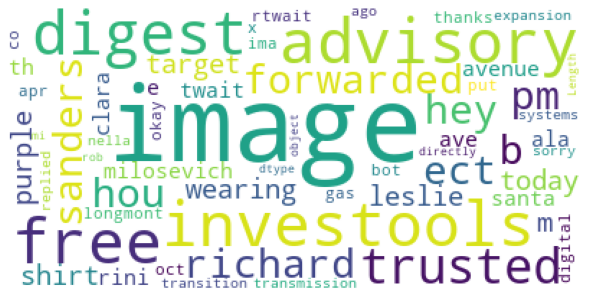

In [50]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

In [ ]:
# Define lemmatizer from nltk
lemma = WordNetLemmatizer()

In [10]:

porter = PorterStemmer()

In [11]:
# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())  
    cleaned_text = " ".join(porter.stem(token) for token in normalized.split())
    return cleaned_text

In [13]:
# Clean the emails in df and print results
text_clean=[]
for text in df['detail_content']:
    text_clean.append(clean(text, stop).split())  
    #print(text_clean)

In [14]:
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

In [27]:
#print(dictionary)

Dictionary(20388 unique tokens: ['account', 'accur', 'acquir', 'acr', 'address']...)


In [15]:
# Define corpus
corpus = [dictionary.doc2bow(text) for text in (text_clean)]

In [ ]:
#print(corpus)

In [68]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, random_state=1,passes=5)

In [19]:
# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

In [20]:
# Print the result
for topic in topics:
    print(topic)

(0, '0.019*"enron" + 0.013*"compani" + 0.008*"employe" + 0.008*"stock" + 0.007*"energi"')
(1, '0.050*"enron" + 0.024*"ect" + 0.011*"hou" + 0.010*"pm" + 0.010*"messag"')
(2, '0.043*"td" + 0.034*"net" + 0.032*"money" + 0.029*"tr" + 0.026*"width"')
(3, '0.036*"imag" + 0.011*"se" + 0.010*"ne" + 0.010*"sp" + 0.010*"wscc"')
(4, '0.009*"imag" + 0.009*"email" + 0.008*"thank" + 0.008*"pleas" + 0.007*"like"')


In [21]:
# Prepare model for visualizatioon
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)


In [81]:
# display the topics
pyLDAvis.enable_notebook()
lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.082962  0.086943       1        1  41.054028
1      0.077343  0.125199       2        1  40.277882
2     -0.328697  0.002131       3        1   2.685483
3      0.078073 -0.257830       4        1   3.198583
4      0.090319  0.043556       5        1  12.784022, topic_info=        Term         Freq        Total Category  logprob  loglift
554      ect  3253.000000  3253.000000  Default  30.0000  30.0000
280      net   715.000000   715.000000  Default  29.0000  29.0000
1835    imag   876.000000   876.000000  Default  28.0000  28.0000
558    enron  9393.000000  9393.000000  Default  27.0000  27.0000
270    money   486.000000   486.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1383   final   154.130936   451.784607   Topic5  -5.6092   0.9816
253    manag   156.950897   640.825867   Topic5  -5.5910   0.6501
282      new   168.857010   987.235901   Topic5  -5.5179   0.2911
615      let   154.249374   631.337463   Topic5  -5.6084   0.6477
264   messag   155.947006  1965.666870   Topic5  -5.5975  -0.4771

[346 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1703      2  0.989887    addin
7508      1  0.009281    adult
7508      5  0.993076    adult
793       1  0.997071   afford
794       1  0.995178  aggress
...     ...       ...      ...
487       5  0.106095     year
742       1  0.946460     york
742       2  0.033093     york
742       4  0.009928     york
742       5  0.006619     york

[813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [58]:
#Compute Perplexity, we can see it has lower perplexity score 
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))


Perplexity:  -8.02895729186133


In [41]:
# Define function that retrieves topic details per row 
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_details_df = topic_details_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score', 'Topic_Keywords']
    return topic_details_df

In [42]:
# Concatenate original text with the outpu of the model detail
contents = pd.DataFrame({'Original Text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

In [50]:
topic_details.head()

,Dominant_Topic,% Score,Topic_Keywords,Original Text
0,0.0,0.9153,"enron, compani, energi, market, employe, time,...","[investool, advisori, free, digest, trust, inv..."
1,1.0,0.9622,"enron, ect, messag, hou, thank, pleas, pm, ori...","[forward, richard, b, sander, hou, ect, pm, ju..."
2,1.0,0.9784,"enron, ect, messag, hou, thank, pleas, pm, ori...","[hey, wear, target, purpl, shirt, today, mine,..."
3,0.0,0.9936,"enron, compani, energi, market, employe, time,...","[lesli, milosevich, santa, clara, avenu, alame..."
4,0.0,0.9942,"enron, compani, energi, market, employe, time,...","[rini, twait, e, th, ave, longmont, co, rtwait..."
